
---

# DL HW2
 - Pretrained Models

In this assignment, you will analyze and compare a few pre-trained models from the field of computer vision.

The assignment is divided into several tasks:

- **EX1 - The Imagenette Dataset (10 pts)**  
- **EX2 - Pretrained Models (20 pts)**  
- **EX3 - Visualizing Feature Maps (30 pts)**  
- **EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50 pts)**  

Note: In this assignment, you will not train any models or aim to reach specific accuracy levels. Instead, you will investigate the behavior of a few pre-trained models.

---

## Grading

The grading for each section is indicated in the title. Grading will be based on the following criteria:

- **Following Instructions**  
- **Presentation**: Clear figures (with labels, titles, etc.), well-written discussions and comments, organized notebook, no leftover debugging prints, and no redundant functions.  
- **Clear and Efficient Code**: Your code should be clear and neat. Write clear comments and avoid `for loops` when vectorized operations are available. Use the GPU when possible.  
- **Discussion**: Ensure you write a discussion whenever it is required.  

---

Submit the fully executed notebook.

---


# EX1 - Imagenette (Small subset of ImageNet) Dataset (10pts)



1.   Download the ```Imagenette``` dataset from ```torchvision``` ([link](https://pytorch.org/vision/0.19/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)). Make sure the set size="160px" to avoid long downloading time.
2. Preprocess the data - resize to 256x256 and take a central crop of size 224. ToTensor, Normalize and so on.
3. Describe the dataset: number of samples for each set, classes labels, classes labels distribtuion (are they balanced?)

4. Plot 5 random samples from each class a present them in a ```num_classes X 5``` (rows X columns) grid.






In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Imagenette
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random
from tqdm import tqdm


In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]     
    )
])

train_set = Imagenette(
    root="./data",
    split="train",
    size="160px",
    transform=transform,
    download=True
)

val_set = Imagenette(
    root="./data",
    split="val",
    size="160px",
    transform=transform,
    download=True
)




Dataset Information
Number of classes: 10
Classes: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Training samples: 9469
Validation samples: 3925


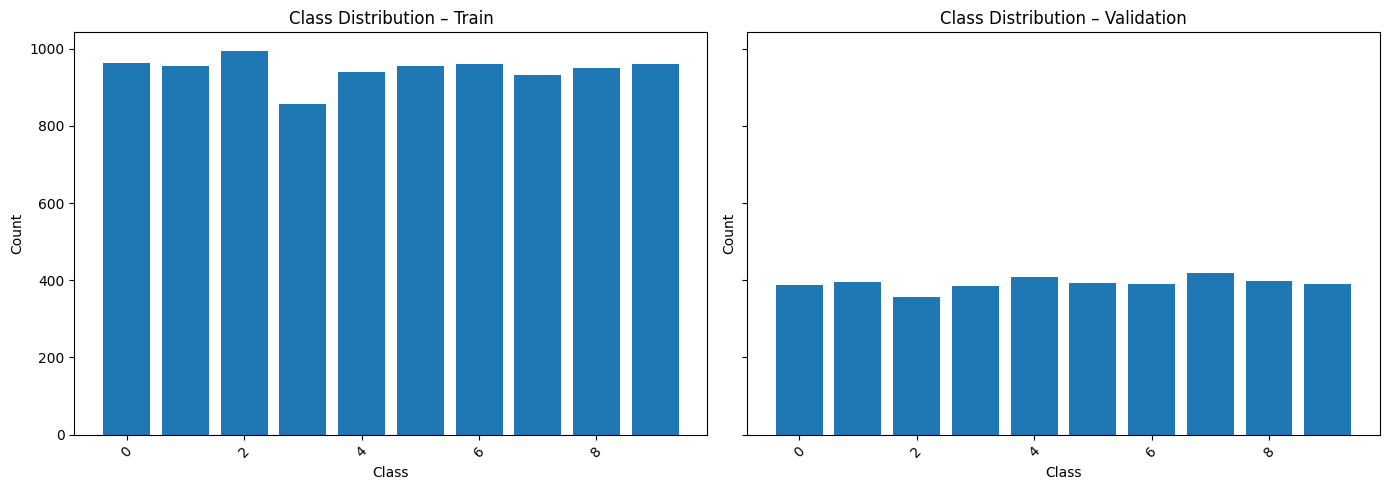

100%|██████████| 10/10 [00:00<00:00, 30.15it/s]


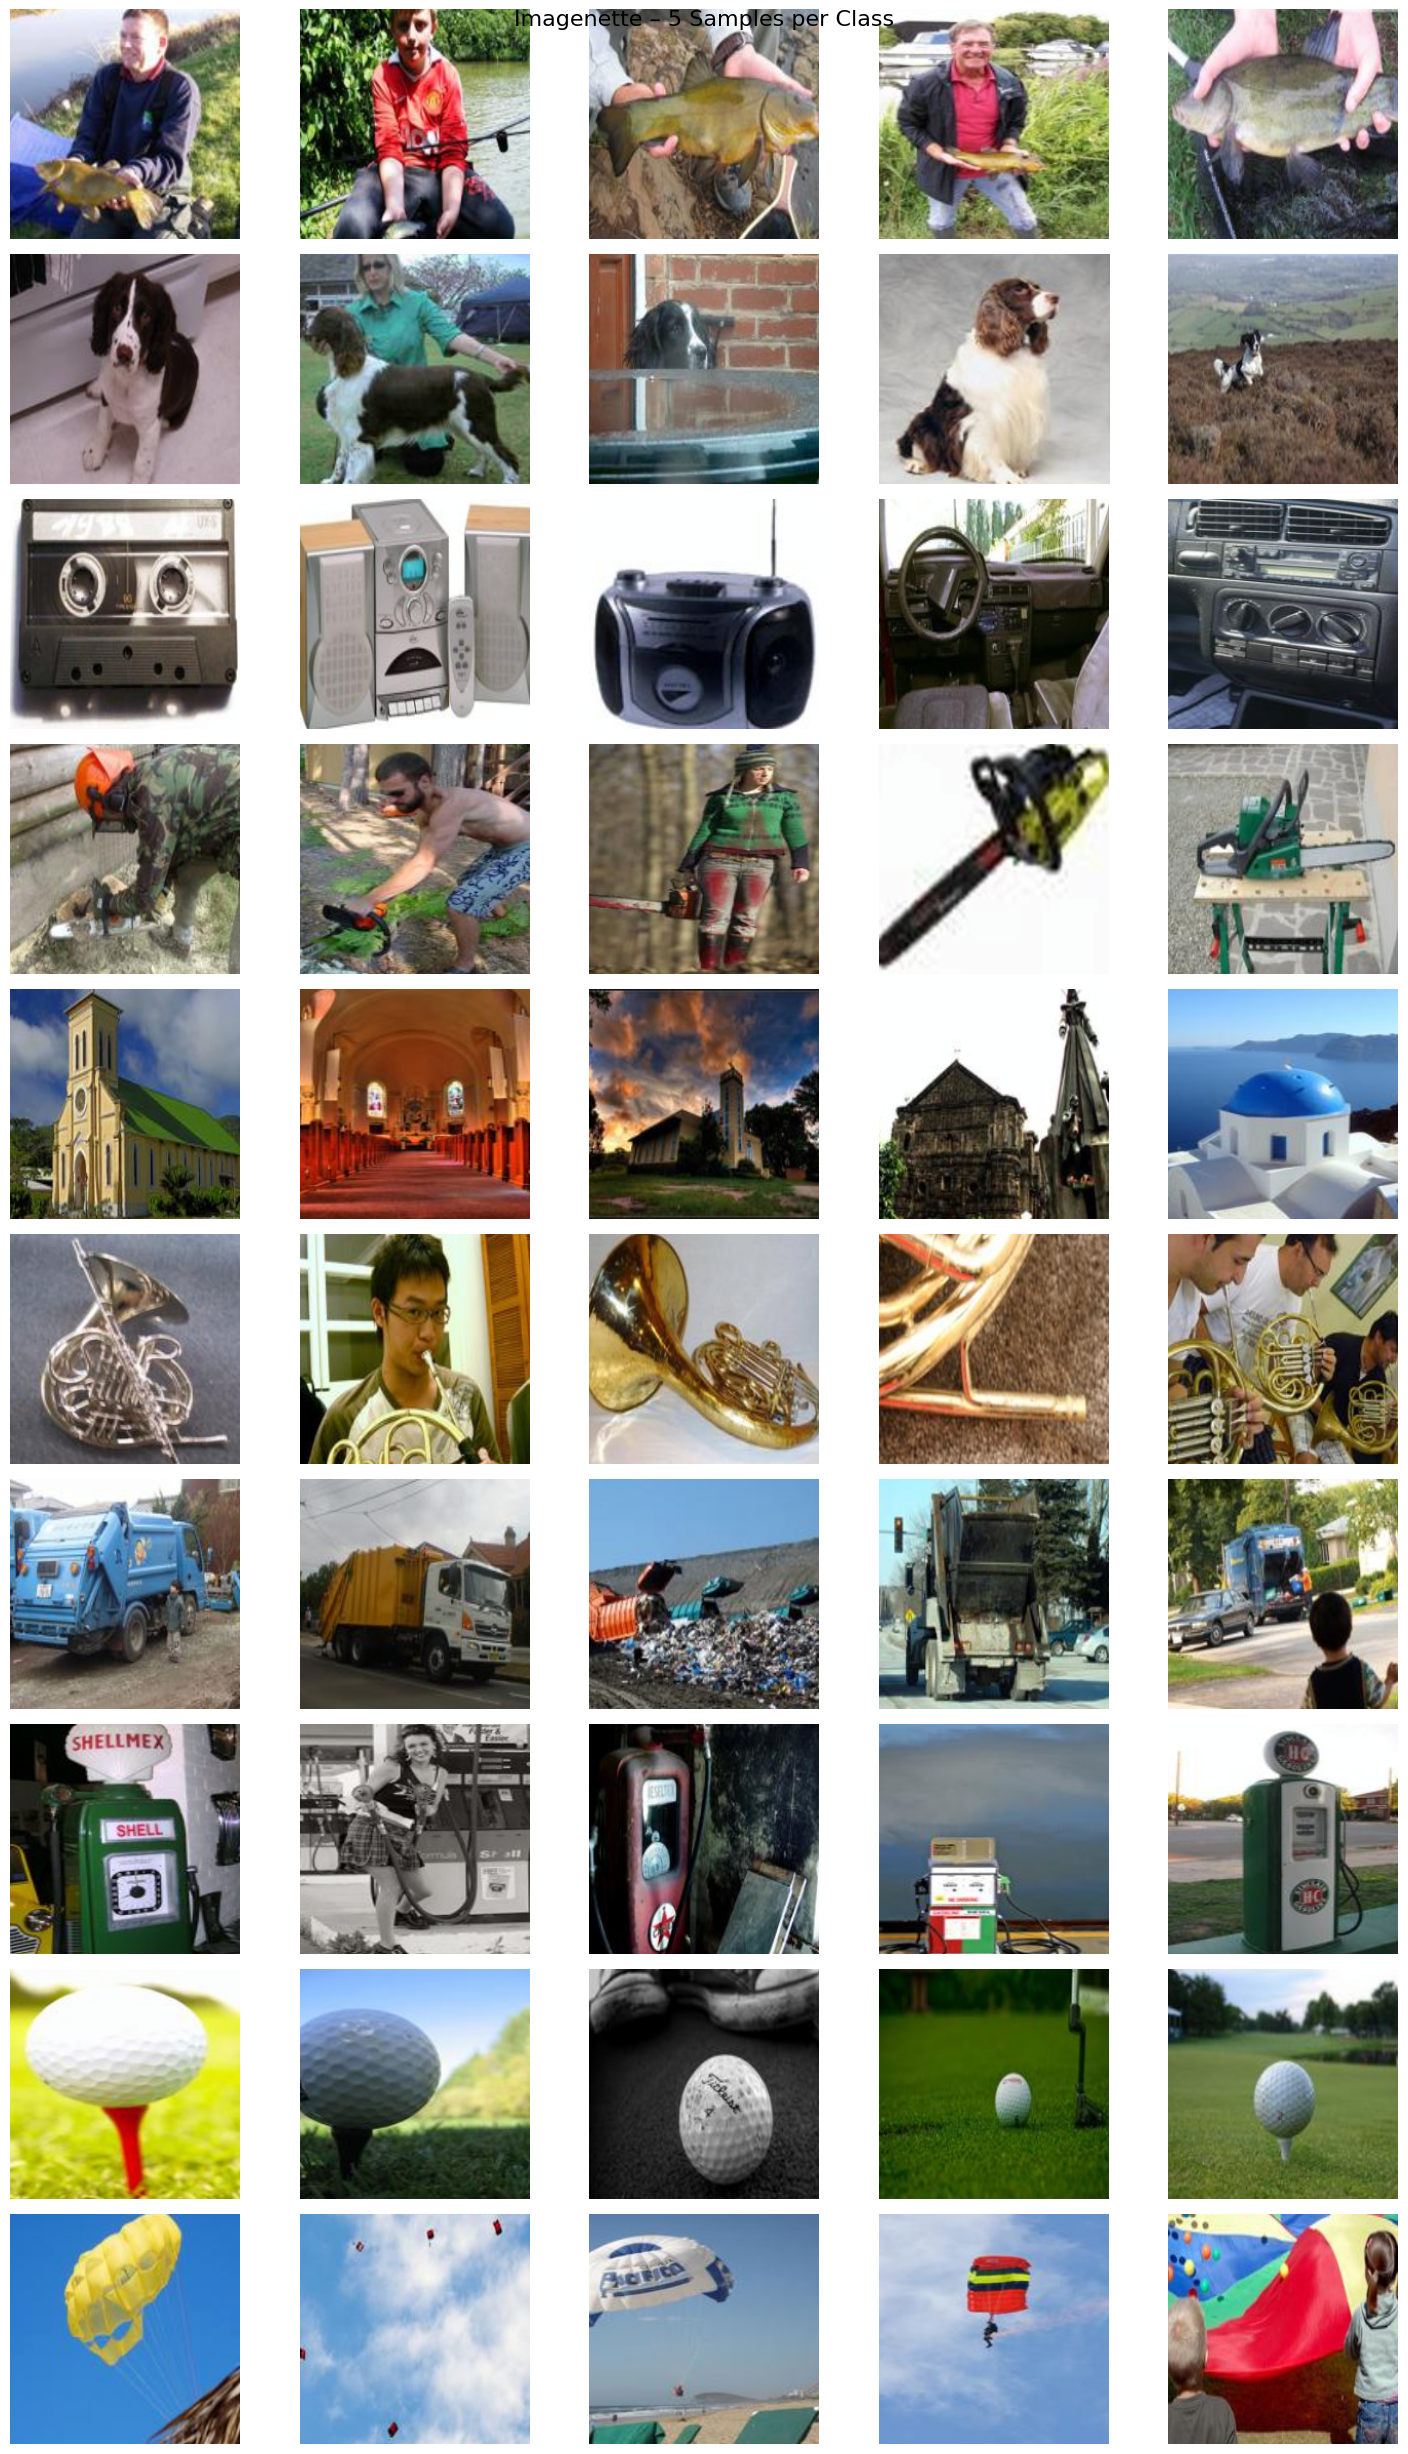

In [11]:
num_train = len(train_set)
num_val = len(val_set)
class_names = train_set.classes
num_classes = len(class_names)

print("Dataset Information")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Training samples: {num_train}")
print(f"Validation samples: {num_val}")

train_labels = [label for _, label in train_set]
val_labels = [label for _, label in val_set]

train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

# print("\n Training class distribution:")
# for idx, name in enumerate(class_names):
#     print(f"{name[0]:20s}: {train_dist[idx]}")

# print("\n Validation class distribution:")
# for idx, name in enumerate(class_names):
#     print(f"{name[0]:20s}: {val_dist[idx]}")

def plot_hist(ax, counter, set_name):
    labels = list(counter.keys())
    counts = list(counter.values())

    ax.bar(labels, counts)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_title(f"Class Distribution – {set_name}")
    ax.tick_params(axis="x", rotation=45)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_hist(axes[0], train_dist, "Train")
plot_hist(axes[1], val_dist, "Validation")

plt.tight_layout()
plt.show()
#Visualization

def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)

indices_per_class = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(train_set):
    indices_per_class[label].append(idx)

fig, axes = plt.subplots(num_classes, 5, figsize=(15, 2.5 * num_classes))

for class_idx in tqdm(range(num_classes)):
    sampled_indices = random.sample(indices_per_class[class_idx], 5)
    for col, sample_idx in enumerate(sampled_indices):
        img, _ = train_set[sample_idx]
        img = denormalize(img)
        axes[class_idx, col].imshow(img)
        axes[class_idx, col].axis("off")

    axes[class_idx, 0].set_ylabel(
        class_names[class_idx],
        rotation=0,
        labelpad=60,
        fontsize=12,
        va="center"
    )

plt.suptitle("Imagenette – 5 Samples per Class", fontsize=16)
plt.tight_layout()
plt.show()

# EX2 - Pretrained models (20pts)

1. Choose 2 models from ```torchvision.models``` ([link](https://pytorch.org/vision/stable/models.html)) that were pretrained on ImageNet. The third model is one of ResNet18/34/50 (the other models can't other ResNet variation).
2. Use ```torch-summary``` to summarize each model for an input of shape ```1x3x224x224```.
3. Describe each model in 2-4 lines. Think carefully what information might be relevant for this homework assignment (see EX3-EX4). It is recommended to read the paper in which each model was first presented but it is not required. You are, however, required to go over model's description in torchvision documentation (see the information tab for ResNet18 for an example [link](https://pytorch.org/vision/0.19/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) )
4. Summarize the similarities and difference between the 3 models.

In [12]:
from torchvision.models import list_models, get_model
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary

from torchinfo import summary as info

print(list_models())

alexnet = get_model("alexnet", weights="DEFAULT")
vit = get_model("vit_b_16", weights="DEFAULT")
resnet = resnet50(ResNet50_Weights.DEFAULT)

print("AlexNet:")
summary(alexnet, input_size=(3, 224, 224))
print("\n\nViT:")
print(info(vit, input_size=(1, 3, 224, 224)))

print("\n\n ResNet50")
summary(resnet, input_size=(3, 224, 224))


['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

c:\Users\PC\anaconda3\envs\midterm\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


AlexNet:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14          

# Model descriptions
### AlexNet

AlexNet is a classic convolutional neural network composed of convolution, ReLU, and max-pooling layers followed by fully connected layers.
It learns visual features in a hierarchical way, starting from simple edges and textures and gradually forming higher-level patterns.
Although relatively shallow by modern standards, it provides clear and interpretable spatial feature maps.

### ResNet-50

ResNet-50 is a deep convolutional network that introduces residual (skip) connections, allowing very deep models to be trained reliably.
These connections help the network learn richer and more abstract features without suffering from vanishing gradients.
As a result, ResNet-50 produces strong, high-level spatial feature representations and serves as a powerful modern CNN baseline.

### ViT-B/16 (Vision Transformer)

ViT-B/16 takes a different approach by splitting the image into fixed-size patches and processing them as a sequence using self-attention.
Instead of convolutions, it relies on transformer layers to model relationships between all parts of the image globally.
Its internal representation is a sequence of patch embeddings rather than a 2D feature map, offering a fundamentally different view of image structure.

# Similarities and differences

### Similarities

* Each model learns hierarchical visual representations that can be reused as feature extractors.

* All can be analyzed by extracting intermediate features for visualization and comparison.

### Differences

* AlexNet and ResNet-50 are convolutional models, while ViT is transformer-based and uses patch embeddings.

* ResNet-50 is significantly deeper and more expressive than AlexNet due to residual connections.

* CNNs produce spatial feature maps (C×H×W), whereas ViT produces a sequence of patch tokens with global attention.

# EX3 - Visualizing feature maps (30pts)
In this section you will visualize the feature maps learned by your chosen models.


*   In a convoultion-based models (i.e., ResNet, ConvNext), use the final conv block. If the image resolution is too small do to maxpooling operations, you may choose a different block.
*   In a vision transformer (ViT), use model output without the cls token (if relevant).

Assignments:


1.   Describe the feature map shape for an input image of shape ```1x3x224x224``` (i.e., ```1x512xHxW``` for some model).
2. Choose 1 class from Imagenette and sample 10 random images.
3. Extract the feature maps from each model and perform PCA on the channel dim and reduce it to 3. The output should be of size ```10x3xHxW```
4. Resize the features to 112x112 and plot the images for each model (3 row x 10 columns)
5. Summarize the similarities and difference between the 3 models according to the PCA for the features you have presented.





device: cpu
Chosen class: ('chain saw', 'chainsaw')
AlexNet feats: torch.Size([10, 256, 6, 6])
ResNet50 feats: torch.Size([10, 2048, 7, 7])
ViT feats: torch.Size([10, 768, 14, 14])


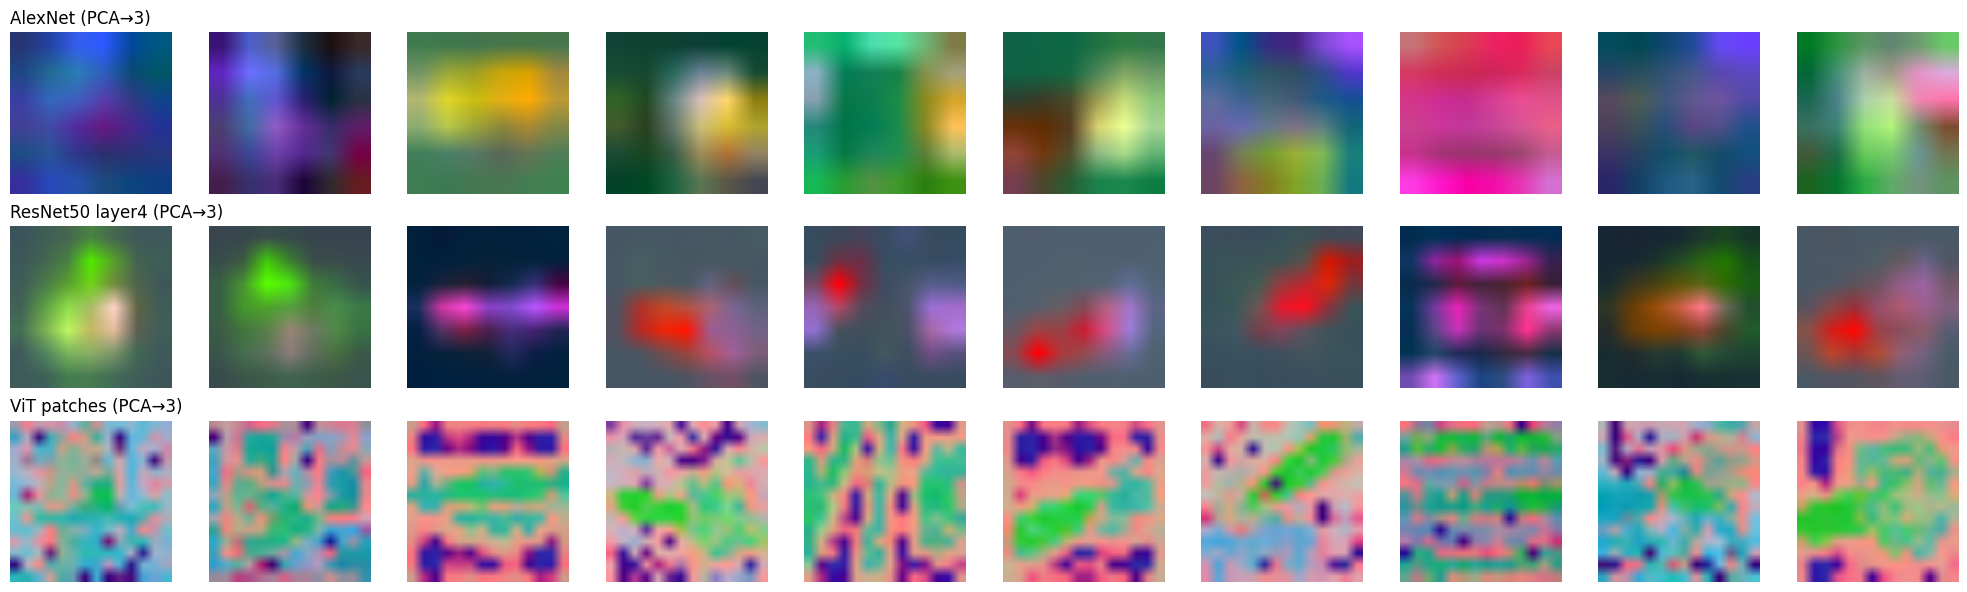

In [17]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---- choose 1 class + sample 10 images from your existing train_set ----
chosen_class_idx = 3 # chainsaw
chosen_class_name = class_names[chosen_class_idx]
print("Chosen class:", chosen_class_name)

sample_indices = random.sample(indices_per_class[chosen_class_idx], 10)
subset = Subset(train_set, sample_indices)
loader = DataLoader(subset, batch_size=10, shuffle=False)

imgs, labels = next(iter(loader))
imgs = imgs.to(device)

# ---- move models to device ----
alexnet = alexnet.to(device).eval()
resnet  = resnet.to(device).eval()
vit     = vit.to(device).eval()

# ---- feature extractors ----
def extract_alexnet_features(model, x):
    with torch.no_grad():
        return model.features(x)  # (B,256,6,6)

def extract_resnet50_layer4(model, x):
    with torch.no_grad():
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)  # (B,2048,7,7)
        return x

def extract_vit_patch_grid(model, x):
    # returns (B,768,14,14) patch embeddings without CLS token
    with torch.no_grad():
        x = model._process_input(x)                  # (B,196,768)
        B = x.shape[0]
        cls = model.class_token.expand(B, -1, -1)    # (B,1,768)
        x = torch.cat([cls, x], dim=1)               # (B,197,768)
        x = x + model.encoder.pos_embedding
        x = model.encoder.dropout(x)
        x = model.encoder.layers(x)
        x = model.encoder.ln(x)                      # (B,197,768)
        x = x[:, 1:, :]                              # (B,196,768)
        x = x.reshape(B, 14, 14, 768).permute(0, 3, 1, 2)  # (B,768,14,14)
        return x

# ---- PCA on channels -> (B,3,H,W) ----
def pca_channels_to_3(feats_bchw):
    B, C, H, W = feats_bchw.shape
    X = feats_bchw.permute(0, 2, 3, 1).reshape(-1, C).detach().cpu().numpy()
    X3 = PCA(n_components=3).fit_transform(X)
    return torch.tensor(X3, dtype=torch.float32).reshape(B, H, W, 3).permute(0, 3, 1, 2)

# ---- resize + plotting ----
def resize_to_112(x):
    return F.interpolate(x, size=(112,112), mode="bilinear", align_corners=False)

def minmax_per_image(img_hwc):
    img = img_hwc - img_hwc.min()
    mx = img.max()
    return img / mx if mx > 0 else img

def plot_3x10(rows, titles):
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))
    for r in range(3):
        for c in range(10):
            img = rows[r][c].permute(1,2,0).detach().cpu().numpy()
            img = minmax_per_image(img)
            axes[r, c].imshow(img)
            axes[r, c].axis("off")
        axes[r, 0].set_title(titles[r], fontsize=12, loc="left")
    plt.tight_layout()
    plt.show()

# ---- run extraction -> PCA -> resize -> plot ----
alex_feats = extract_alexnet_features(alexnet, imgs)
res_feats  = extract_resnet50_layer4(resnet, imgs)
vit_feats  = extract_vit_patch_grid(vit, imgs)

print("AlexNet feats:", alex_feats.shape)  # expected (10,256,6,6)
print("ResNet50 feats:", res_feats.shape)  # expected (10,2048,7,7)
print("ViT feats:", vit_feats.shape)       # expected (10,768,14,14)

alex_pca = resize_to_112(pca_channels_to_3(alex_feats))
res_pca  = resize_to_112(pca_channels_to_3(res_feats))
vit_pca  = resize_to_112(pca_channels_to_3(vit_feats))

plot_3x10(
    [alex_pca, res_pca, vit_pca],
    ["AlexNet (PCA→3)", "ResNet50 layer4 (PCA→3)", "ViT patches (PCA→3)"]
)


# PCA Feature Comparison (AlexNet, ResNet50, ViT)

### AlexNet:
The PCA maps are smooth and low-resolution, capturing coarse shapes and dominant color regions.
Features focus on basic textures and object blobs, with limited semantic separation.

### ResNet50:
The PCA maps are sharper and more localized, often highlighting the main object more clearly.
Features show stronger semantic structure and better object–background separation than AlexNet.

### ViT:
The PCA maps exhibit a clear patch-based, grid-like pattern reflecting the token structure.
Features emphasize global structure but appear less spatially smooth compared to CNNs.

### Overall:
CNN-based models (AlexNet, ResNet50) produce spatially continuous features, while ViT produces patch-level representations.
ResNet50 yields the most semantically meaningful features among the three, consistent with its depth and residual design.

# EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50pts)
Also know ans "few-shot/ Zero-shot learning".
Perform KNN classification using the feature vectors from each of the 3 models between the train and test set of Imagenette.


## Visualizing the embedding layer distribution.
* Write an ```extract_embedding(dataloader, model, model_name)``` function that takes in a dataloader and a model and return the ```N x Num_features``` matrix for that set. Make sure that shuffle is off.
* You may write different condition for different models. I.e., the embedding in a ViT model is the ```CLS``` token.

* Plot the t-SNE of the train set for each of the 3 models. Color label the points according to the class labels (see t-SNE implementation by sklearn).

* Write a 2-3 lines disscussion about the data distribution of each model and their comparison.


## Build a KNN ```class``` with the following methods:


*   ```init()```: takes the num_classes and other useful information.
* ```extract_embedding(X, model)```: Extracts the embedding vector for the entire train set using the model. X_features should be ```Nxnum_ft```. Call the function from the previous section.

*   ```fit(X_train, y_train, model)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and stores it as ```self.X_train_ft``` and ```self.y_labels``` (the labels from the train set).  


*   ```predict(X_test, model, n_neighbors)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and performs KNN for a given K. Returns the predicted_labels.
* ```compute_accuracy(y_true, y_pred)```.


## Compare the KNN accuracy
using each of the 3 models for $K\in[1,3,5 ]$ and report the results in a table or a graph. Summarize the results in 2-4 lines.


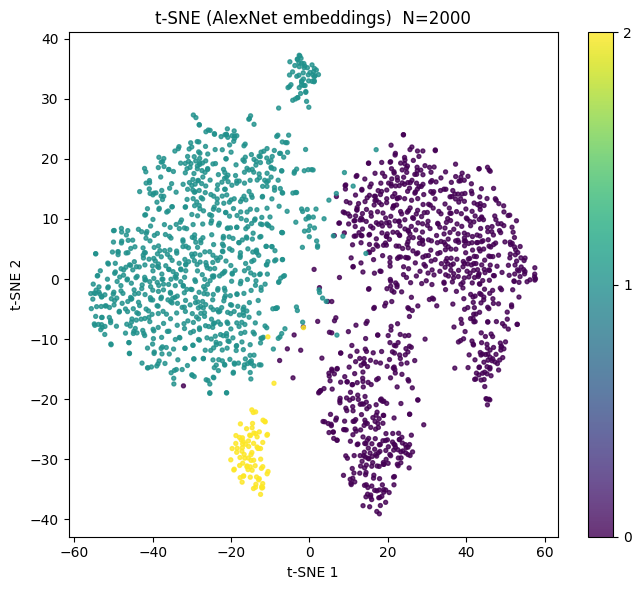

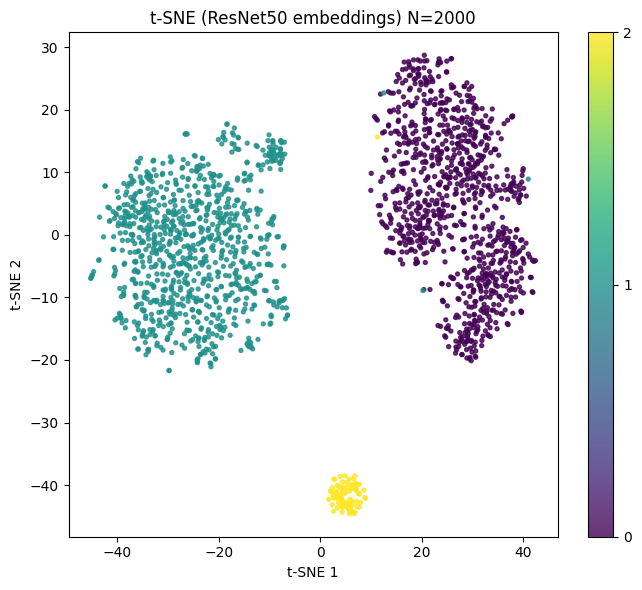

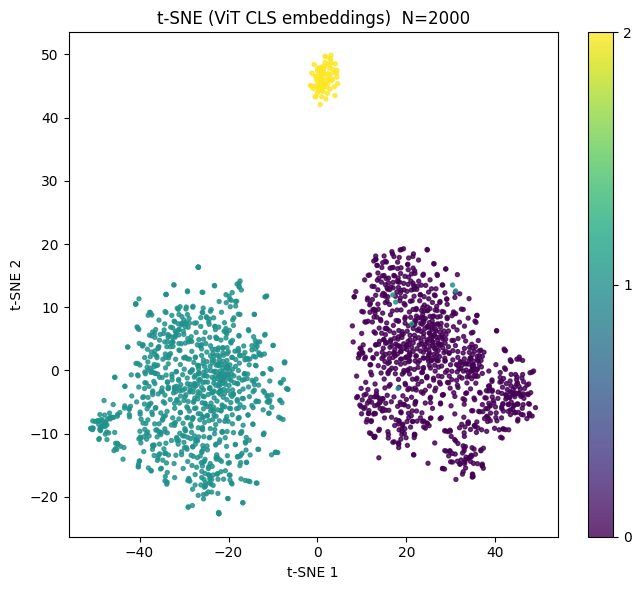

alexnet   K=1  acc=0.8831
alexnet   K=3  acc=0.8950
alexnet   K=5  acc=0.9093
resnet50  K=1  acc=0.9890
resnet50  K=3  acc=0.9924
resnet50  K=5  acc=0.9924
vit       K=1  acc=0.9952
vit       K=3  acc=0.9957
vit       K=5  acc=0.9957


K                1         3         5
model                                 
alexnet   0.883057  0.895032  0.909299
resnet50  0.989045  0.992357  0.992357
vit       0.995159  0.995669  0.995669

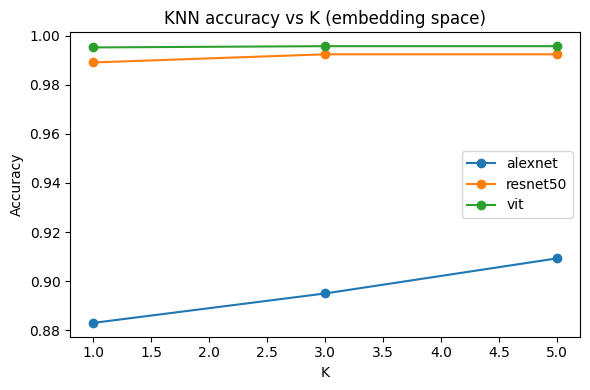

In [18]:
# =========================
# EX4: Embeddings + t-SNE + KNN (AlexNet / ResNet50 / ViT-B/16)
# Assumes you already have: train_set, val_set, alexnet, resnet, vit, device
# =========================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import pandas as pd

# ---------- dataloaders (shuffle MUST be False) ----------
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---------- embedding extractors ----------
def _alexnet_embed(model, x):
    # embedding = 4096-dim vector before final classifier layer
    x = model.features(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    x = model.classifier[:-1](x)   # -> (B, 4096)
    return x

def _resnet50_embed(model, x):
    # embedding = 2048-dim vector before fc
    x = model.conv1(x); x = model.bn1(x); x = model.relu(x); x = model.maxpool(x)
    x = model.layer1(x); x = model.layer2(x); x = model.layer3(x); x = model.layer4(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)        # -> (B, 2048)
    return x

def _vit_cls_embed(model, x):
    # embedding = CLS token (768-dim)
    x = model._process_input(x)                 # (B, 196, 768)
    B = x.shape[0]
    cls = model.class_token.expand(B, -1, -1)   # (B, 1, 768)
    x = torch.cat([cls, x], dim=1)              # (B, 197, 768)
    x = x + model.encoder.pos_embedding
    x = model.encoder.dropout(x)
    x = model.encoder.layers(x)
    x = model.encoder.ln(x)                     # (B, 197, 768)
    cls_tok = x[:, 0, :]                        # (B, 768)
    return cls_tok

def extract_embedding(dataloader, model, model_name, max_points=None):
    """
    Returns:
      X_ft: (N, D) numpy float32
      y:    (N,)   numpy int64
    max_points: set to an int (e.g. 2000) to speed up t-SNE; set None for full set.
    """
    model.eval()
    X_list, y_list = [], []
    seen = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            if max_points is not None and seen >= max_points:
                break

            imgs = imgs.to(device)
            labels = labels.cpu().numpy()

            if model_name.lower() == "alexnet":
                ft = _alexnet_embed(model, imgs)
            elif model_name.lower() == "resnet50":
                ft = _resnet50_embed(model, imgs)
            elif model_name.lower() == "vit":
                ft = _vit_cls_embed(model, imgs)
            else:
                raise ValueError("model_name must be one of: 'alexnet', 'resnet50', 'vit'")

            ft = ft.cpu().numpy().astype(np.float32)

            if max_points is not None:
                remaining = max_points - seen
                ft = ft[:remaining]
                labels = labels[:remaining]

            X_list.append(ft)
            y_list.append(labels)
            seen += len(labels)

    X_ft = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0).astype(np.int64)
    return X_ft, y

# ---------- t-SNE plotting ----------
def plot_tsne(X_ft, y, title, num_classes=10, max_points=None):
    # t-SNE is slow on big N; max_points is handled by extract_embedding
    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=0)
    X2 = tsne.fit_transform(X_ft)

    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y, s=8, alpha=0.8)
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(scatter, ticks=range(num_classes))
    plt.tight_layout()
    plt.show()

# --- run t-SNE on train set (set max_points=None for full, or e.g. 2000 for faster) ---
TSNE_MAX = 2000  # change to None if you insist on full train set

X_alex_tr, y_tr = extract_embedding(train_loader, alexnet.to(device), "alexnet", max_points=TSNE_MAX)
X_res_tr,  _    = extract_embedding(train_loader, resnet.to(device),  "resnet50", max_points=TSNE_MAX)
X_vit_tr,  _    = extract_embedding(train_loader, vit.to(device),     "vit", max_points=TSNE_MAX)

plot_tsne(X_alex_tr, y_tr, f"t-SNE (AlexNet embeddings)  N={len(y_tr)}")
plot_tsne(X_res_tr,  y_tr, f"t-SNE (ResNet50 embeddings) N={len(y_tr)}")
plot_tsne(X_vit_tr,  y_tr, f"t-SNE (ViT CLS embeddings)  N={len(y_tr)}")

# ---------- KNN class (Euclidean) ----------
class KNNEmbeddingClassifier:
    def __init__(self, num_classes, metric="euclidean"):
        self.num_classes = num_classes
        self.metric = metric
        self.X_train_ft = None
        self.y_labels = None

    def fit(self, train_loader, model, model_name):
        X, y = extract_embedding(train_loader, model, model_name, max_points=None)
        self.X_train_ft = torch.tensor(X, dtype=torch.float32)
        self.y_labels = torch.tensor(y, dtype=torch.long)
        return self

    @staticmethod
    def compute_accuracy(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        return (y_true == y_pred).mean()

    def predict(self, test_loader, model, model_name, n_neighbors=1, chunk_size=256):
        assert self.X_train_ft is not None, "Call fit() first."
        X_test, y_true = extract_embedding(test_loader, model, model_name, max_points=None)

        Xtr = self.X_train_ft.to(device)
        ytr = self.y_labels.to(device)

        Xt = torch.tensor(X_test, dtype=torch.float32).to(device)
        preds = []

        with torch.no_grad():
            for i in range(0, Xt.shape[0], chunk_size):
                xq = Xt[i:i+chunk_size]                          # (b, D)
                d = torch.cdist(xq, Xtr)                          # (b, Ntrain)
                nn_idx = torch.topk(d, k=n_neighbors, largest=False).indices  # (b, k)
                nn_labels = ytr[nn_idx]                           # (b, k)

                # majority vote
                b = nn_labels.shape[0]
                out = torch.empty(b, dtype=torch.long, device=device)
                for j in range(b):
                    counts = torch.bincount(nn_labels[j], minlength=self.num_classes)
                    out[j] = torch.argmax(counts)
                preds.append(out.cpu().numpy())

        y_pred = np.concatenate(preds, axis=0)
        return y_true, y_pred

# ---------- compare accuracies for K in [1,3,5] ----------
Ks = [1, 3, 5]
results = []

knn = KNNEmbeddingClassifier(num_classes=num_classes)

for model_name, model in [("alexnet", alexnet.to(device).eval()),
                          ("resnet50", resnet.to(device).eval()),
                          ("vit", vit.to(device).eval())]:

    knn.fit(train_loader, model, model_name)

    for k in Ks:
        y_true, y_pred = knn.predict(test_loader, model, model_name, n_neighbors=k, chunk_size=256)
        acc = knn.compute_accuracy(y_true, y_pred)
        results.append({"model": model_name, "K": k, "accuracy": acc})
        print(f"{model_name:8s}  K={k}  acc={acc:.4f}")

df = pd.DataFrame(results).pivot(index="model", columns="K", values="accuracy")
display(df)

# optional: quick plot
plt.figure(figsize=(6,4))
for m in df.index:
    plt.plot(df.columns, df.loc[m].values, marker="o", label=m)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN accuracy vs K (embedding space)")
plt.legend()
plt.tight_layout()
plt.show()


### Embedding Distribution

AlexNet embeddings show partially overlapping clusters, indicating limited class separability.
ResNet50 produces compact and well-separated clusters, reflecting strong semantic representations.
ViT embeddings exhibit the clearest separation, suggesting that global self-attention captures high-level structure effectively.

### KNN Classification Results

AlexNet achieves lower KNN accuracy, improving slightly with larger 𝐾.
ResNet50 and ViT achieve consistently high accuracy across all 𝐾 values, with ViT performing best overall.
These results align with the t-SNE visualizations and demonstrate that more structured embedding spaces lead to better few-shot KNN performance.